### ECSE 415: Introduction to Computer Vision
### Assignment 2
Imaad Bukhari 

Student ID: 261089801


#### Question 1: Image Stitching


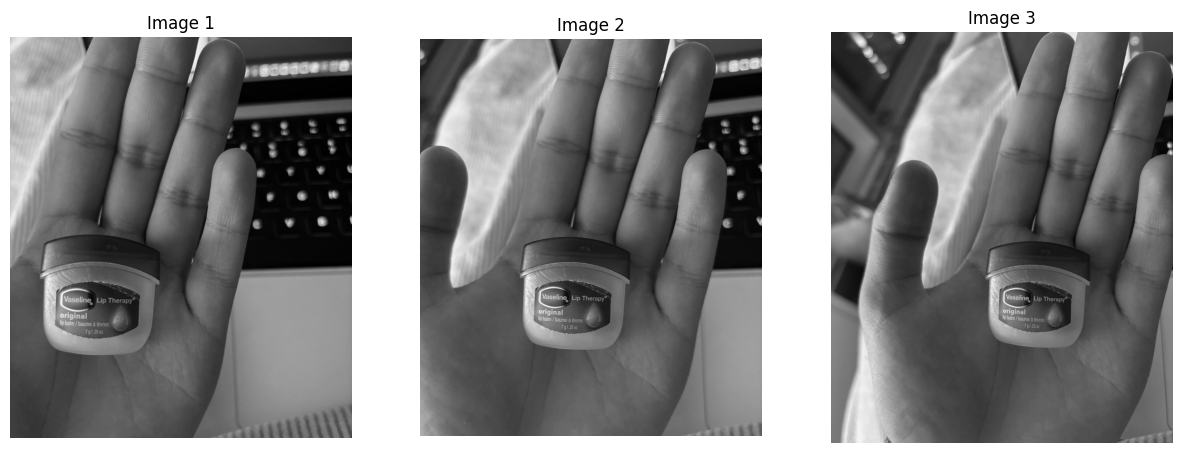

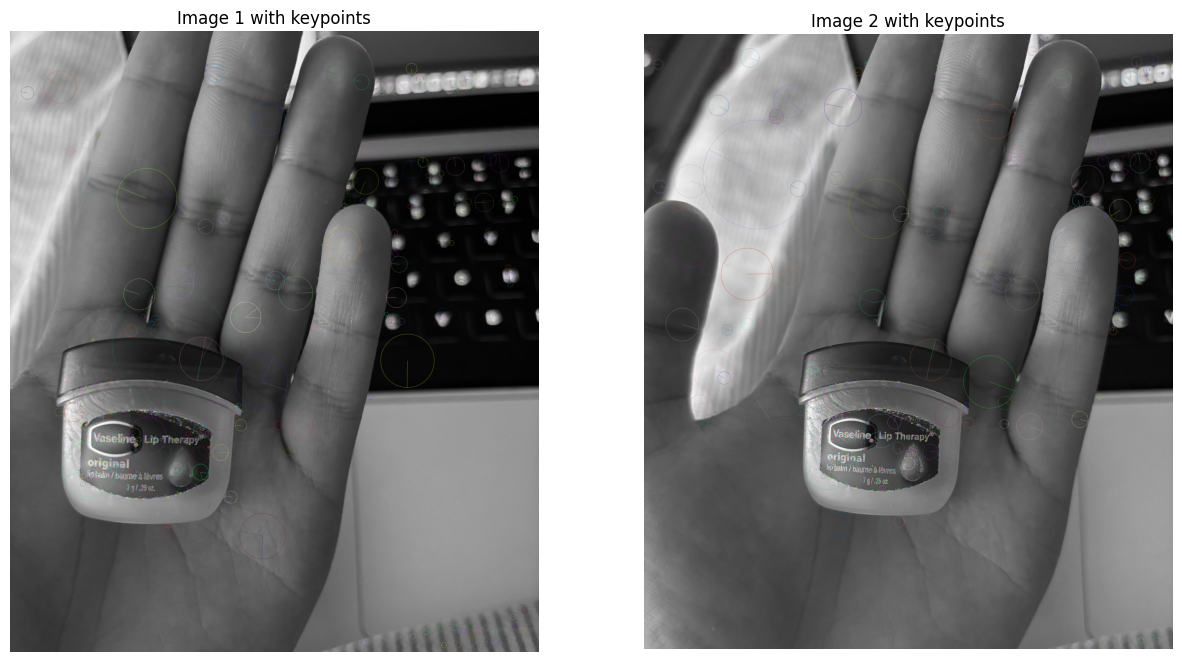

In [48]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Change this path for marking
path = "/Users/imaadbukhari/Documents/ECSE 415"

# Loads and converts to grayscale
def load_and_convert_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    return image

grayscale_image_1 = load_and_convert_image(path + '/image1.jpg')
grayscale_image_2 = load_and_convert_image(path + '/image2.jpg')
grayscale_image_3 = load_and_convert_image(path + '/image3.jpg')

plt.figure(figsize=(15, 15))
plt.subplot(131)
plt.imshow(grayscale_image_1, cmap='gray')
plt.title('Image 1')
plt.axis('off')
plt.subplot(132)
plt.imshow(grayscale_image_2, cmap='gray')
plt.title('Image 2')
plt.axis('off')
plt.subplot(133)
plt.imshow(grayscale_image_3, cmap='gray')
plt.title('Image 3')
plt.axis('off')
plt.show()


###Based on code from tutorials

sift = cv2.SIFT_create()
keypoints1, descriptors1 = sift.detectAndCompute(grayscale_image_1, None)
keypoints2, descriptors2 = sift.detectAndCompute(grayscale_image_2, None)

# Draw keypoints on the images
image1_with_keypoints = cv2.drawKeypoints(grayscale_image_1, keypoints1, grayscale_image_1, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
image2_with_keypoints = cv2.drawKeypoints(grayscale_image_2, keypoints2, grayscale_image_2, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)     

plt.figure(figsize=(15, 15))
plt.subplot(121)   
plt.imshow(image1_with_keypoints, cmap='gray')
plt.title('Image 1 with keypoints')
plt.axis('off')
plt.subplot(122)
plt.imshow(image2_with_keypoints, cmap='gray')
plt.title('Image 2 with keypoints')
plt.axis('off')
plt.show()



The above images show the SIFT Keypoints on images 1 and 2. Note that they are a bit hard to see. 

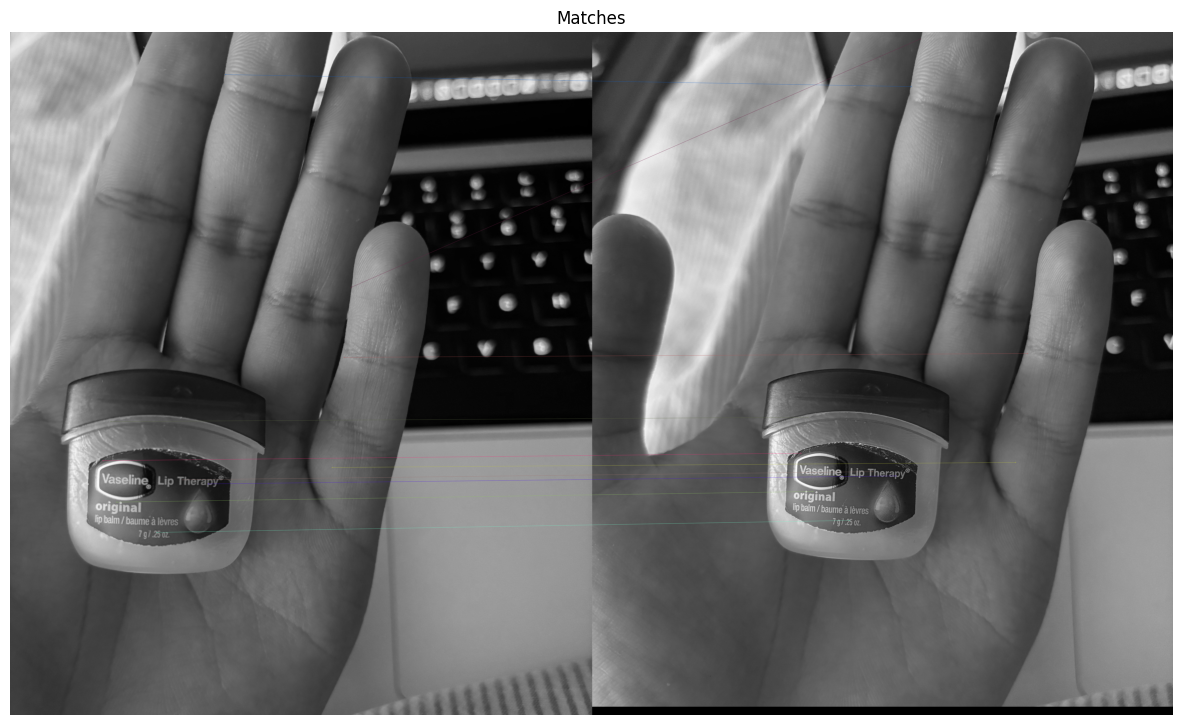

In [3]:
### Based on code from tutorials

bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
matches = bf.match(descriptors1, descriptors2)
matches = sorted(matches, key = lambda x:x.distance)

matches_image = cv2.drawMatches(grayscale_image_1, keypoints1, grayscale_image_2, keypoints2, matches[:10], None, flags=cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=(15, 15))
plt.imshow(matches_image)
plt.title('Matches')
plt.axis('off')
plt.show()


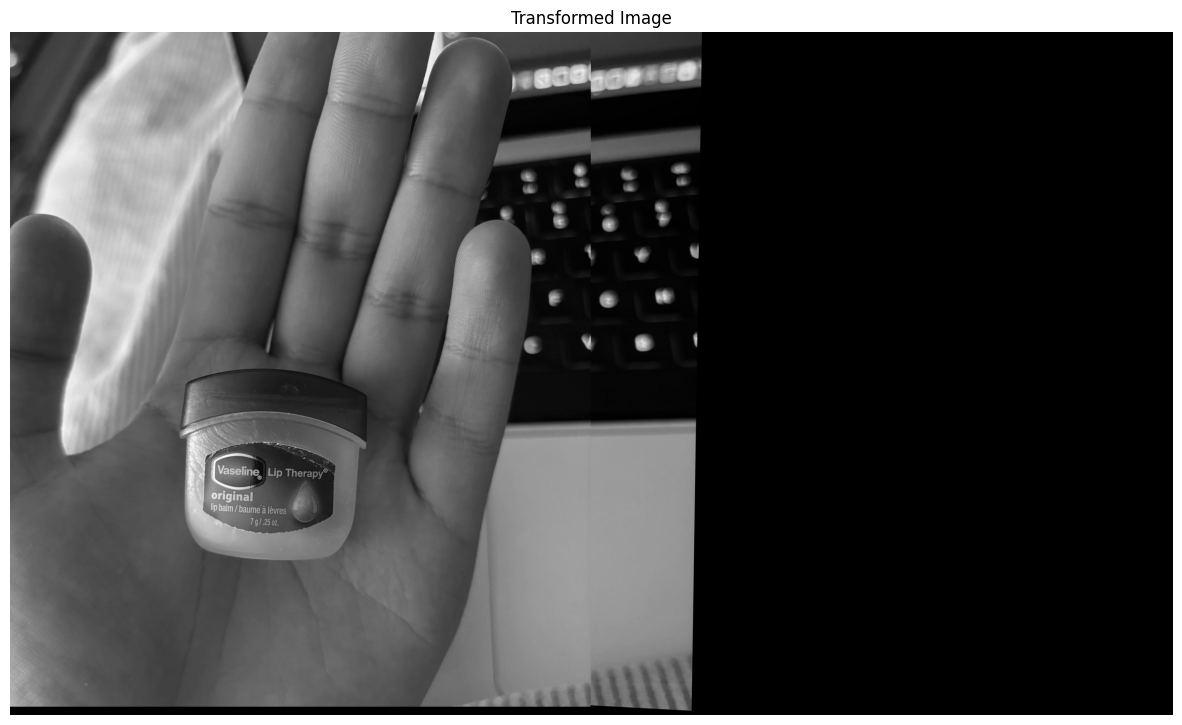

In [4]:
###Ransac homography from tutorials

Good_matches = []
for i,m in enumerate(matches):
    if m.distance < 1000:
        Good_matches.append((m.trainIdx, m.queryIdx))

mp1 = np.float32([keypoints1[i].pt for (_, i) in Good_matches])
mp2 = np.float32([keypoints2[i].pt for (i, _) in Good_matches])

H, _ = cv2.findHomography(mp1, mp2, cv2.RANSAC, 4)

warped_image = cv2.warpPerspective(grayscale_image_1, H, (grayscale_image_1.shape[1] + grayscale_image_2.shape[1], grayscale_image_1.shape[0]))
warped_image[0:grayscale_image_2.shape[0], 0:grayscale_image_2.shape[1]] = grayscale_image_2

plt.figure(figsize=(15, 15))
plt.imshow(warped_image, cmap='gray')
plt.title('Transformed Image')
plt.axis('off')
plt.show()


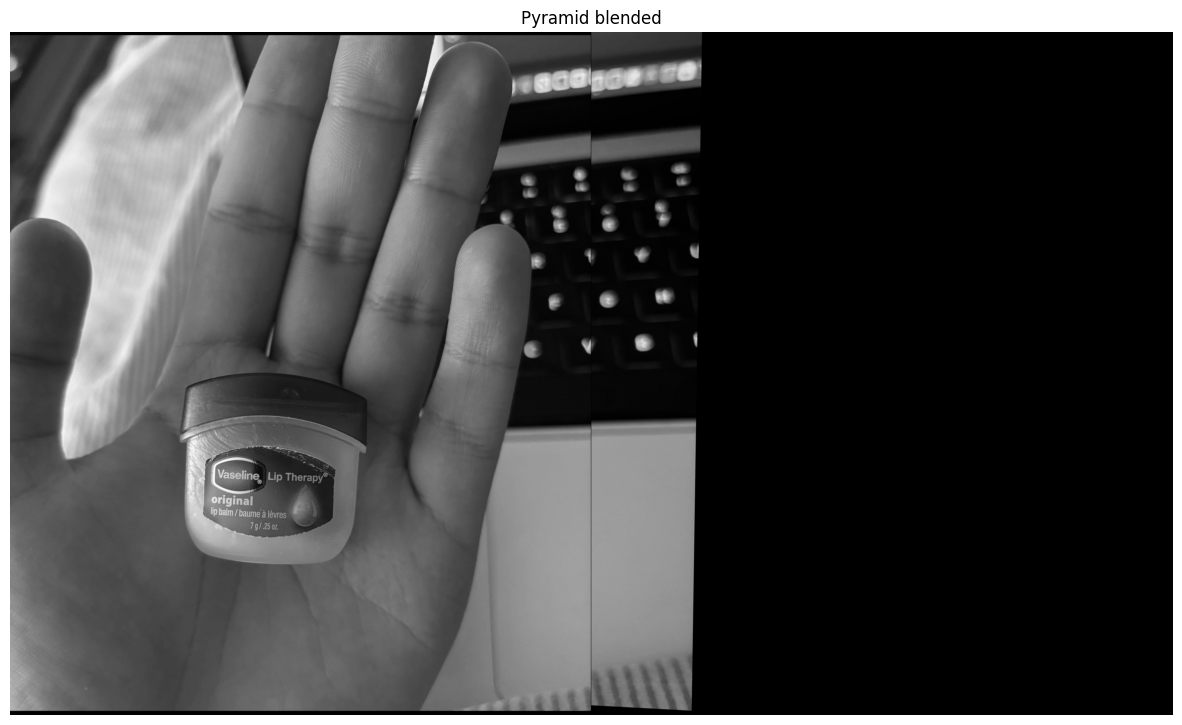

In [5]:
### Image Stitching with pyramid blending. Some help from copilot on how to integrate the pyramid blending

import math

def pyramid_blend(right, left):
  
    
    h1, w1 = right.shape
    h2, w2 = left.shape

    if h1 > h2:
        left = cv2.copyMakeBorder(left, math.ceil((h1-h2)/2), math.floor((h1-h2)/2), 0, 0, cv2.BORDER_CONSTANT, 0)
    elif h2 > h1:
        right = cv2.copyMakeBorder(right, math.ceil((h2-h1)/2), math.floor((h2-h1)/2), 0, 0, cv2.BORDER_CONSTANT, 0)

    if w1 > w2:
        left = cv2.copyMakeBorder(left, 0, 0, 0, w1-w2, cv2.BORDER_CONSTANT, 0)
    elif w2 > w1:
        right = cv2.copyMakeBorder(right, 0, 0, 0, w2-w1, cv2.BORDER_CONSTANT, 0)

    levels = 2

    gpA = [right.copy()]
    gpB = [left.copy()]
    for i in range(levels):
        gpA.append(cv2.pyrDown(gpA[-1]))
        gpB.append(cv2.pyrDown(gpB[-1]))

    lpA = [gpA[levels-1]]
    lpB = [gpB[levels-1]]
    for i in range(levels-1, 0, -1):
        hG, wG = gpA[i-1].shape
        upSamp = cv2.pyrUp(gpA[i], dstsize=(wG, hG))
        diff = cv2.subtract(gpA[i-1], upSamp)
        lpA.append(diff)

        upSamp = cv2.pyrUp(gpB[i], dstsize=(wG, hG))
        diff = cv2.subtract(gpB[i-1], upSamp)
        lpB.append(diff)

    combinedList = []
    for i in range(len(lpA)):
        la = lpA[i]
        lb = lpB[i]
        cols = la.shape[1]

        combined = np.hstack((lb[:, :cols//2], la[:, cols//2:]))
        combinedList.append(combined)

    blend = combinedList[0]
    for i in range(1, len(combinedList)):
        hB, wB = combinedList[i].shape
        blend = cv2.pyrUp(blend)
        if blend.shape[0] != hB or blend.shape[1] != wB:
            blend = cv2.resize(blend, (wB, hB))

        blend = cv2.add(blend, combinedList[i])

    
    return blend


grayscale_image_12 = pyramid_blend(warped_image, grayscale_image_2)
plt.figure(figsize=(15,10))
plt.imshow(grayscale_image_12, cmap='gray')
plt.title("Pyramid blended")
plt.axis("off")
plt.show()


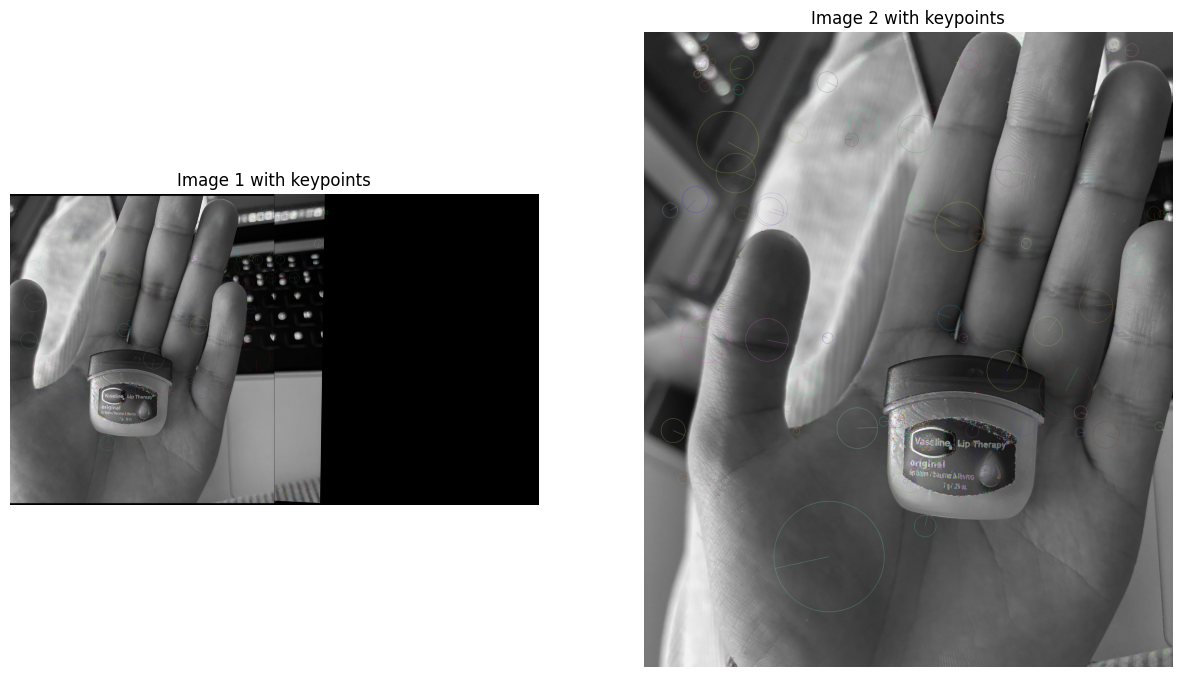

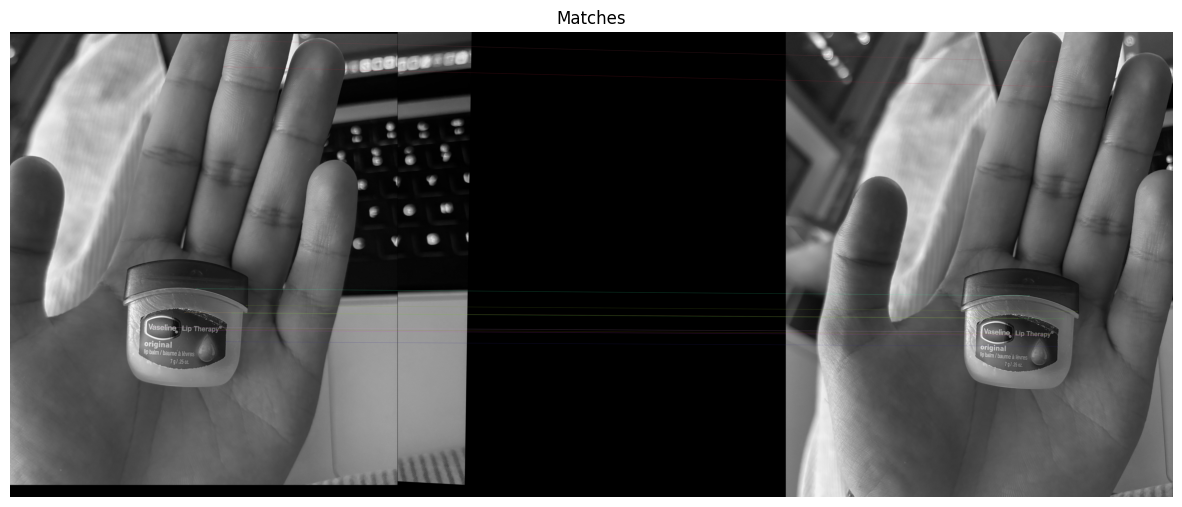

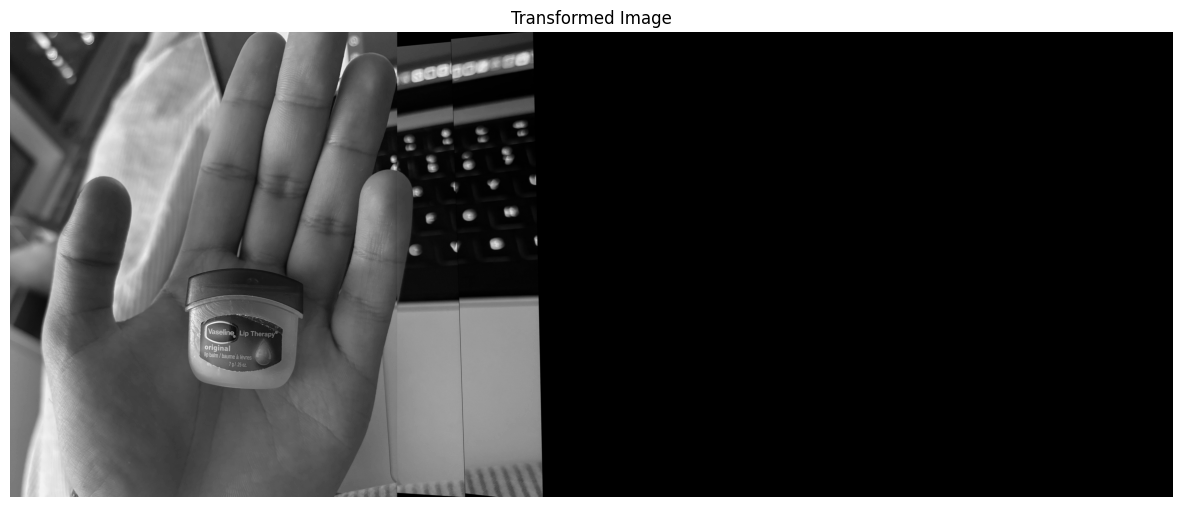

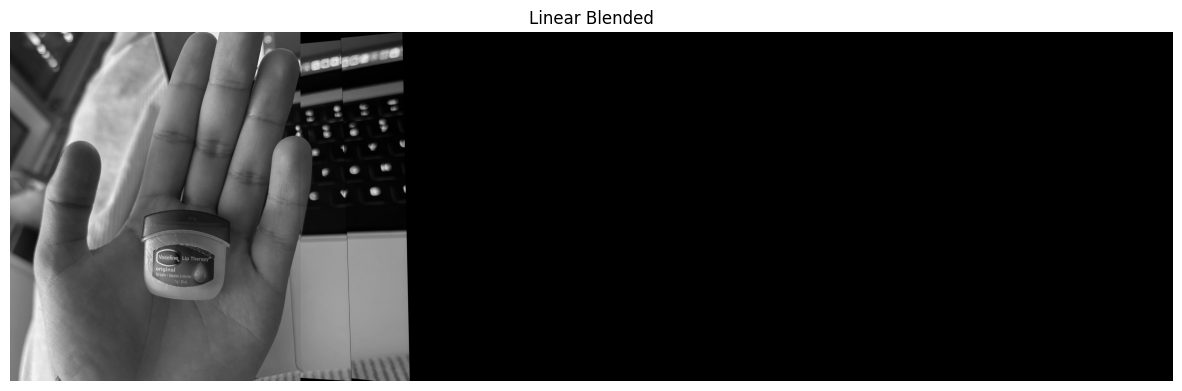

In [6]:
### Repeating steps and linear blending. Some help from copilot on how to integrate the linear blending

sift = cv2.SIFT_create()
keypoints1, descriptors1 = sift.detectAndCompute(grayscale_image_12, None)
keypoints2, descriptors2 = sift.detectAndCompute(grayscale_image_3, None)

# Draw keypoints on the images
image1_with_keypoints = cv2.drawKeypoints(grayscale_image_12, keypoints1, grayscale_image_12, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
image2_with_keypoints = cv2.drawKeypoints(grayscale_image_3, keypoints2, grayscale_image_3, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.figure(figsize=(15, 15))    
plt.subplot(121)
plt.imshow(image1_with_keypoints, cmap='gray')
plt.title('Image 1 with keypoints')
plt.axis('off')
plt.subplot(122)
plt.imshow(image2_with_keypoints, cmap='gray')
plt.title('Image 2 with keypoints')
plt.axis('off')
plt.show()

bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
matches = bf.match(descriptors1, descriptors2)
matches = sorted(matches, key = lambda x:x.distance)

matches_image = cv2.drawMatches(grayscale_image_12, keypoints1, grayscale_image_3, keypoints2, matches[:10], None, flags=cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=(15, 15))
plt.imshow(matches_image)
plt.title('Matches')
plt.axis('off')
plt.show()

Good_matches = []
for i,m in enumerate(matches):
    if m.distance < 1000:
        Good_matches.append((m.trainIdx, m.queryIdx))

mp1 = np.float32([keypoints1[i].pt for (_, i) in Good_matches])
mp2 = np.float32([keypoints2[i].pt for (i, _) in Good_matches])

H, _ = cv2.findHomography(mp1, mp2, cv2.RANSAC, 4)


h1, w1 = grayscale_image_12.shape[:2]
h2, w2 = grayscale_image_3.shape[:2]
warped_image = cv2.warpPerspective(grayscale_image_12, H, (w1 + w2, max(h1, h2)))

#Some extra work was needed to ensure the image was displayed correctly

mask = np.zeros((max(h1, h2), w1 + w2), dtype=np.uint8)
mask[0:h2, 0:w2] = 1

for y in range(h2):
    for x in range(w2):
        if x < warped_image.shape[1] and y < warped_image.shape[0]:  
            if mask[y, x] == 1:
                warped_image[y, x] = grayscale_image_3[y, x]

plt.figure(figsize=(15, 15))
plt.imshow(warped_image, cmap='gray')
plt.title('Transformed Image')
plt.axis('off')
plt.show()

# Linear blending implementation
# Some guidance from lecture slides, with some help from copilot on implementation
def linear_blend(img1, img2):
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]
    

    result = np.zeros((max(h1, h2), w1 + w2), dtype=np.uint8)
    

    overlap = min(w1, w2) // 4
    
   
    result[0:h2, 0:w2] = img2
    
   
    blend_mask = np.zeros((max(h1, h2), w1 + w2))
    
   
    for x in range(w2 - overlap, w2):
        
        alpha = (x - (w2 - overlap)) / overlap
        col = int(x)
        if 0 <= col < blend_mask.shape[1]:
            blend_mask[:, col] = alpha
    

    blend_mask[:, w2:] = 1
    
 
    for y in range(result.shape[0]):
        for x in range(result.shape[1]):
            if x < warped_image.shape[1] and y < warped_image.shape[0]: 
                result[y, x] = (1 - blend_mask[y, x]) * result[y, x] + blend_mask[y, x] * warped_image[y, x]
    
    return result

# Apply linear blending
linear_blended = linear_blend(warped_image, grayscale_image_3)

plt.figure(figsize=(15, 10))
plt.imshow(linear_blended, cmap='gray')
plt.title("Linear Blended")
plt.axis("off")
plt.show()



#### Questions on Image Stitching

Generally, the SIFT points were quite good. It picked up features in the main object as well as my hand in the background. However, it was not perfect. For image 1 and 2, there was a clear mismatch in which it caught the tip of my pinky finger and matched it with the tip of my middle finger in another. There were a couple of other instances such as one part of the label being perceived as the another part of it, but it was generally quite accurate. 

The pyramid blending was much better than the linear blending. Even in grayscale, there is a clear difference in colour between both sides of the seam for the linearly blended image. For the pyramid blending, it was pretty much indistinguishable color wise, although there was a clear seam due to the homography. This comes down to how each works. Linear blending only works around the seam between images, while pyramid blending uses Laplacian pyramids to affect the image as a whole in different places. This corrects for the lighting differences that cause the noticeable change at the seam. 


#### Question 2: PCA

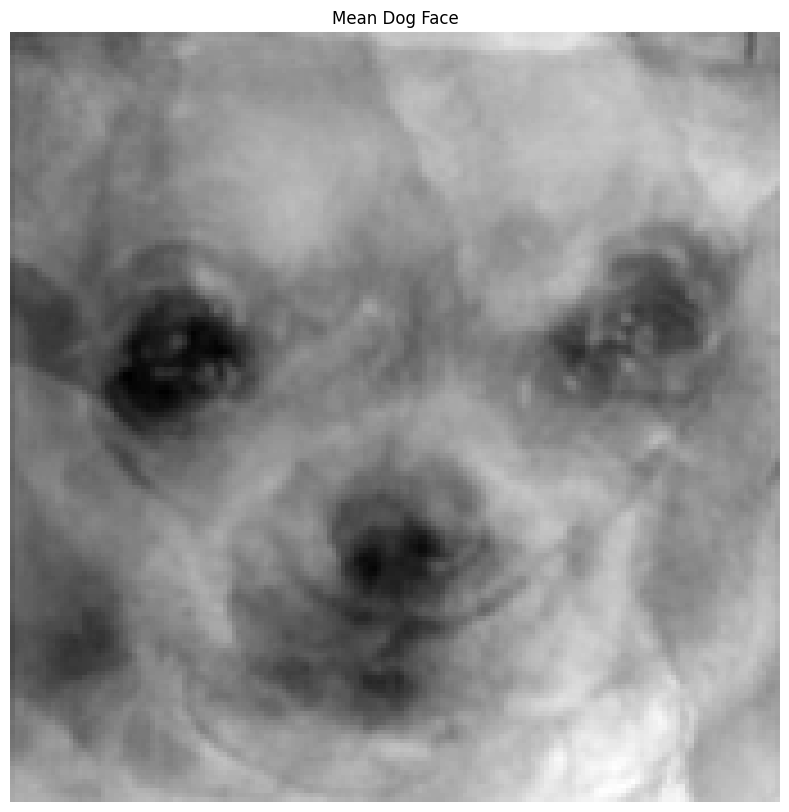

In [7]:
#Grayscale

def load_and_convert_image_resized(image_path, target_shape):
    image = load_and_convert_image(image_path)
    return cv2.resize(image, target_shape)


target_shape = (170, 170)  

gray_dog_1 = load_and_convert_image_resized(path + '/Q2/chihuahua-1.jpg', target_shape)
gray_dog_2 = load_and_convert_image_resized(path + '/Q2/chihuahua-2.jpg', target_shape)
gray_dog_3 = load_and_convert_image_resized(path + '/Q2/chihuahua-3.jpg', target_shape)
gray_dog_4 = load_and_convert_image_resized(path + '/Q2/chihuahua-4.jpg', target_shape)
gray_dog_5 = load_and_convert_image_resized(path + '/Q2/chihuahua-5.jpg', target_shape)
gray_dog_6 = load_and_convert_image_resized(path + '/Q2/chihuahua-6.jpg', target_shape)
gray_dog_7 = load_and_convert_image_resized(path + '/Q2/chihuahua-7.jpg', target_shape)
gray_dog_8 = load_and_convert_image_resized(path + '/Q2/chihuahua-8.jpg', target_shape)

gray_muffin_1 = load_and_convert_image_resized(path + '/Q2/muffin-1.jpeg', target_shape)
gray_muffin_2 = load_and_convert_image_resized(path + '/Q2/muffin-2.jpeg', target_shape)
gray_muffin_3 = load_and_convert_image_resized(path + '/Q2/muffin-3.jpeg', target_shape)
gray_muffin_4 = load_and_convert_image_resized(path + '/Q2/muffin-4.jpeg', target_shape)
gray_muffin_5 = load_and_convert_image_resized(path + '/Q2/muffin-5.jpeg', target_shape)
gray_muffin_6 = load_and_convert_image_resized(path + '/Q2/muffin-6.jpeg', target_shape)
gray_muffin_7 = load_and_convert_image_resized(path + '/Q2/muffin-7.jpeg', target_shape)
gray_muffin_8 = load_and_convert_image_resized(path + '/Q2/muffin-8.jpeg', target_shape)


mean_dog = np.mean([gray_dog_1, gray_dog_2, gray_dog_3, gray_dog_4, gray_dog_5, gray_dog_6, gray_dog_7, gray_dog_8], axis=0)

mean_dog_face = mean_dog.astype(np.uint8)
plt.figure(figsize=(15, 10))
plt.imshow(mean_dog_face, cmap='gray')
plt.title("Mean Dog Face")
plt.axis("off")
plt.show()



In [21]:
###Implementing PCA from scratch. Mostly knowledge from class 

images = np.array([gray_dog_1.flatten(), gray_dog_2.flatten(), gray_dog_3.flatten(), gray_dog_4.flatten(), gray_dog_5.flatten(), gray_dog_6.flatten(), gray_dog_7.flatten(), gray_dog_8.flatten()])

mean_image = np.mean(images, axis=0)
standardized_images = images - mean_image

### Using covariance matrix took too long to run. Copilot suggested using SVD instead

U, S, Vt = np.linalg.svd(standardized_images, full_matrices=False)
sorted_indices = np.argsort(S)[::-1]
sorted_singular_values = S[sorted_indices]
sorted_eigenvalues = (sorted_singular_values**2) / (len(images)-1)
sorted_eigenvectors = Vt[sorted_indices]

print("Eigenvalues in descending order:")
print(sorted_eigenvalues)





Eigenvalues in descending order:
[3.11889890e+07 1.86672766e+07 1.28910904e+07 1.03756074e+07
 8.93468182e+06 5.63399593e+06 4.12094602e+06 2.40179753e-22]


Number of components to explain 90% of variance: 6
Number of components to explain 96% of variance: 7


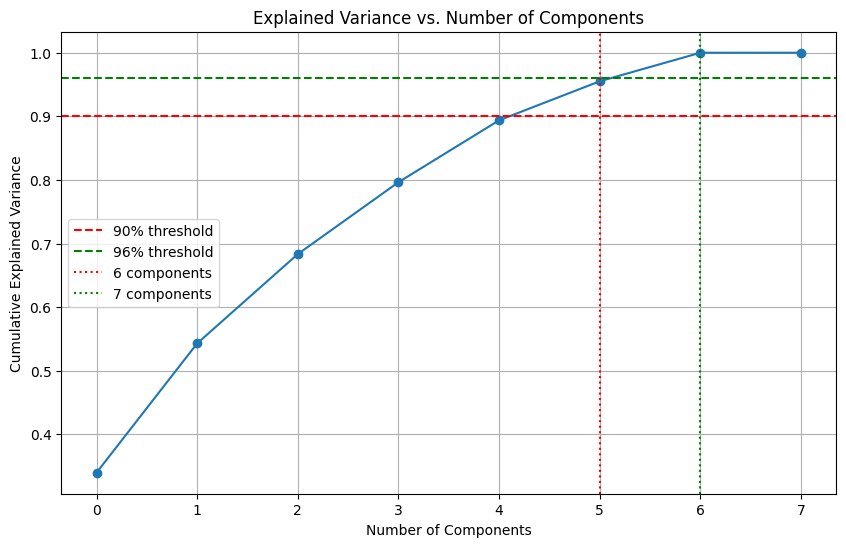

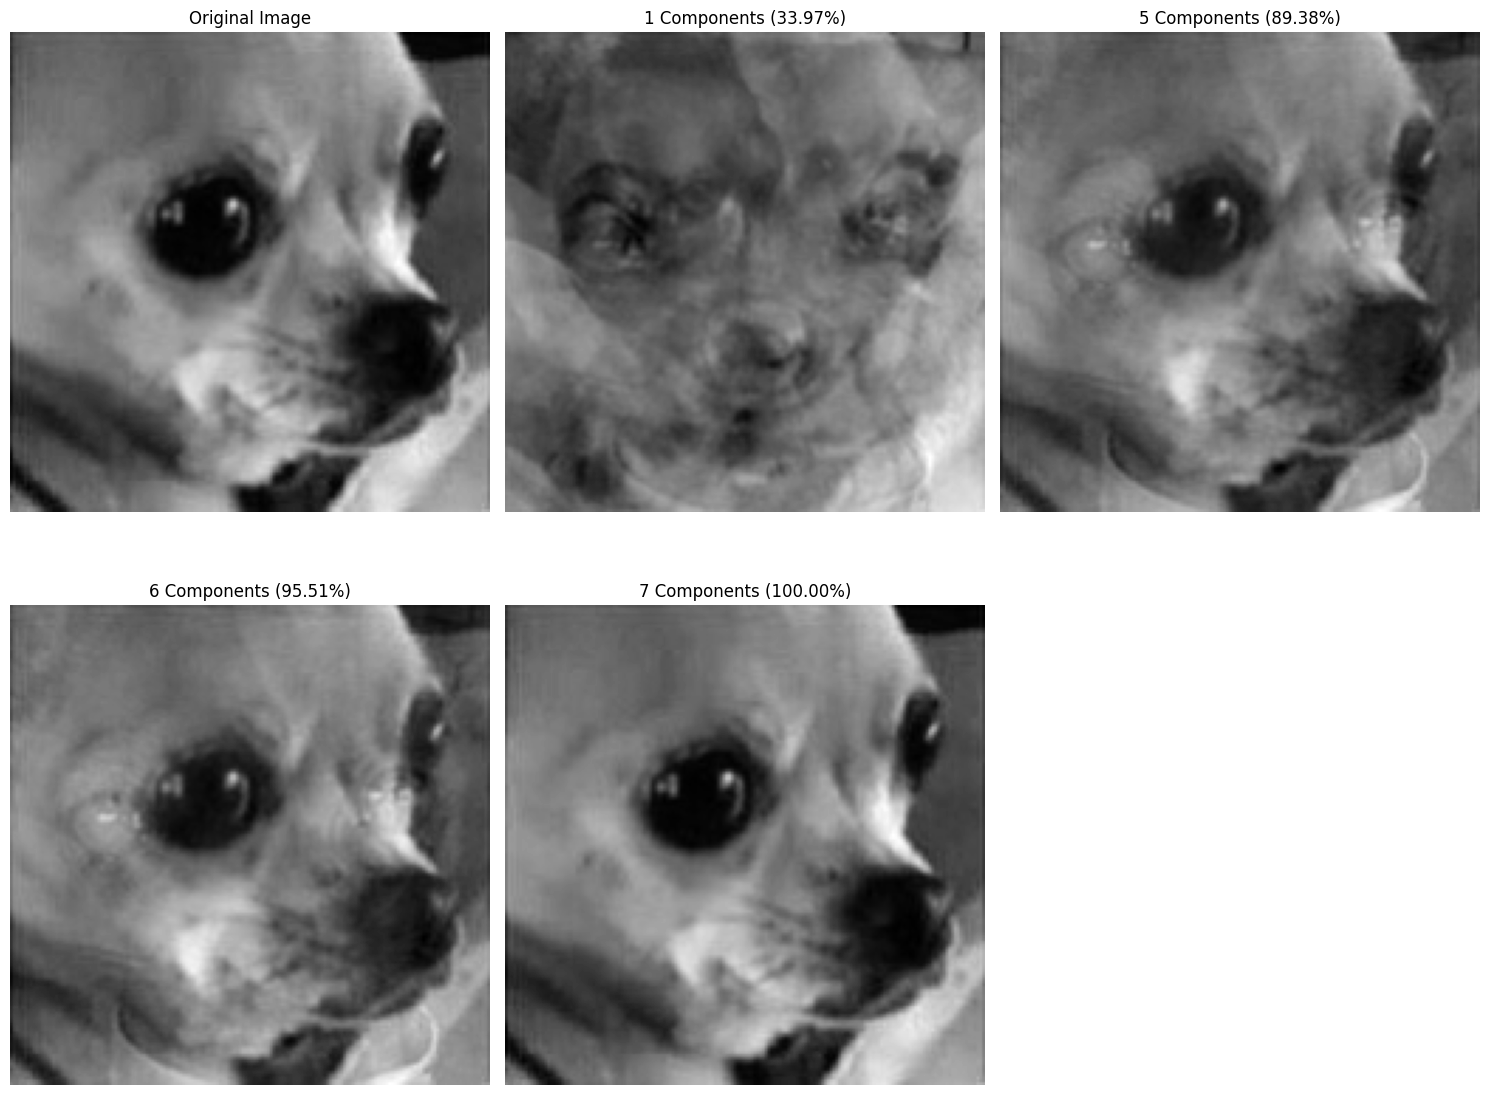


Reconstruction Errors:
MSE with 1 components (33.97% variance): 2509.6918
MSE with 5 components (89.38% variance): 201.5147
MSE with 6 components (95.51% variance): 154.2436
MSE with 7 components (100.00% variance): 0.0000


In [32]:
# Compute eigenvalues and cumulative variance
total_variance = np.sum(sorted_eigenvalues)
cumulative_variance_ratio = np.cumsum(sorted_eigenvalues) / total_variance

# Find number of components for 90% and 95% variance
components_90 = np.argmax(cumulative_variance_ratio >= 0.9) + 1
components_95 = np.argmax(cumulative_variance_ratio >= 0.96) + 1

print("Number of components to explain 90% of variance:", components_90)
print("Number of components to explain 96% of variance:", components_95)

# Plot cumulative variance to visualize the difference between thresholds
plt.figure(figsize=(10, 6))
plt.plot(cumulative_variance_ratio[:20], marker='o')  # Show first 20 components
plt.axhline(y=0.9, color='r', linestyle='--', label='90% threshold')
plt.axhline(y=0.96, color='g', linestyle='--', label='96% threshold')
plt.axvline(x=components_90-1, color='r', linestyle=':', label=f'{components_90} components')
plt.axvline(x=components_95-1, color='g', linestyle=':', label=f'{components_95} components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.grid(True)
plt.legend()
plt.show()

# Correct reconstruction function for SVD-based eigenvectors
def reconstruct_image(image, mean_image, eigenvectors, num_components):
    # Flatten the image if it's not already flattened
    flat_image = image.flatten() if len(image.shape) > 1 else image
    
    # Project data onto principal components
    projected = np.dot(flat_image - mean_image, eigenvectors[:num_components].T)
    
    # Reconstruct the image
    reconstructed = mean_image + np.dot(projected, eigenvectors[:num_components])
    
    return reconstructed

# Compare original and reconstructed images
n_components = [1, 5, components_90, components_95]
reconstructed_images = []

plt.figure(figsize=(15, 12))

# Add original image for comparison
plt.subplot(2, 3, 1)
plt.imshow(gray_dog_1, cmap='gray')
plt.title("Original Image")
plt.axis('off')

# Show reconstructions with different numbers of components
for i, num_components in enumerate(n_components):
    plt.subplot(2, 3, i+2)
    reconstructed_image = reconstruct_image(images[0], mean_image, sorted_eigenvectors, num_components)
    reconstructed_image = reconstructed_image.reshape(target_shape)
    reconstructed_images.append(reconstructed_image)
    plt.imshow(reconstructed_image, cmap='gray')
    plt.title(f"{num_components} Components ({cumulative_variance_ratio[num_components-1]:.2%})")
    plt.axis('off')

plt.tight_layout()
plt.show()

# Calculate reconstruction errors
print("\nReconstruction Errors:")
for i, num_components in enumerate(n_components):
    original = images[0]
    reconstructed = reconstruct_image(original, mean_image, sorted_eigenvectors, num_components)
    mse = np.mean((original - reconstructed) ** 2)
    print(f"MSE with {num_components} components ({cumulative_variance_ratio[num_components-1]:.2%} variance): {mse:.4f}")




##### Discussion

I'm not sure if I did something wrong, but I got the same number of components for 90% and 95% of the variance. Thus, I just bumped it up to 96% so that I could have a different number. 

Based on the graph, we can see that there are diminishing returns. With 7 components there is no error, but going from 1 component to 5 components reduced the MSE by 2300. This is quite evident when looking at the images too. 

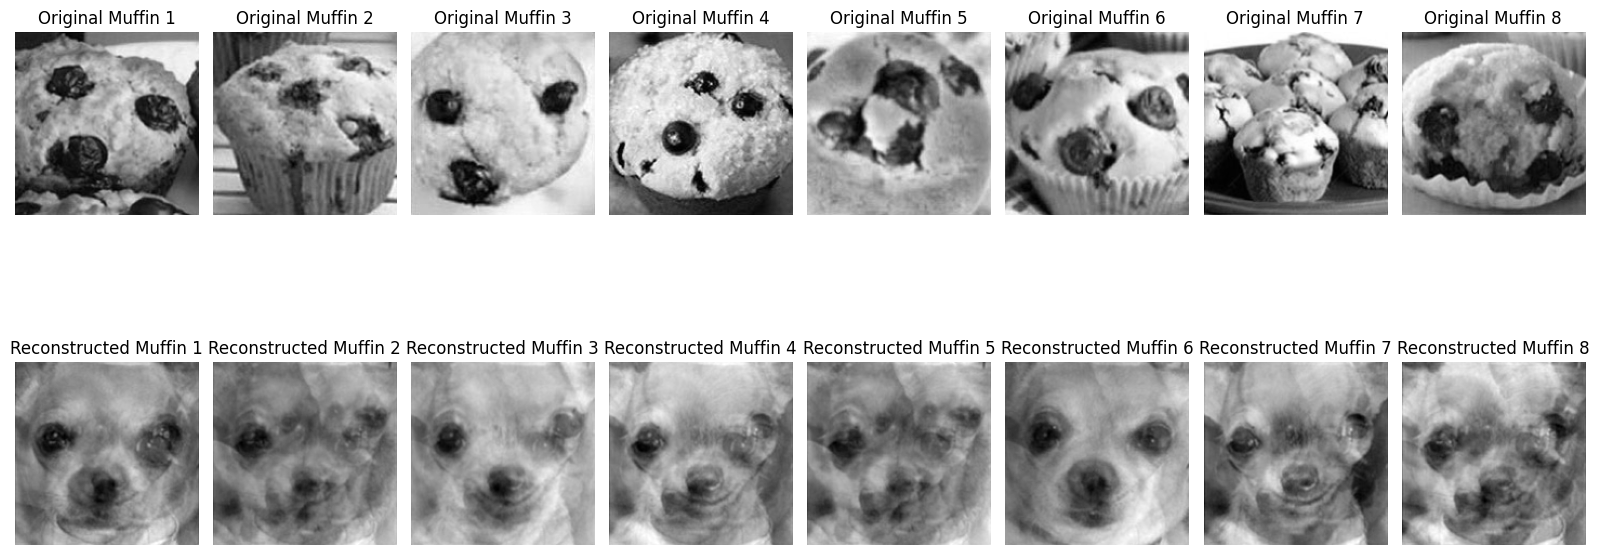

In [39]:
# Putting muffin into this model

k = components_90
muffin_images = [
    gray_muffin_1, gray_muffin_2, gray_muffin_3, gray_muffin_4,
    gray_muffin_5, gray_muffin_6, gray_muffin_7, gray_muffin_8
]

flattened_muffins = np.array([muffin.flatten() for muffin in muffin_images])

muffin_projections = []
for i, muffin in enumerate(flattened_muffins):

    centered_muffin = muffin - mean_image
    
    projection = np.dot(centered_muffin, sorted_eigenvectors[:k].T)
    muffin_projections.append(projection)
    



muffin_projections = np.array(muffin_projections)


reconstructed_muffins = []
for i, projection in enumerate(muffin_projections):

    reconstructed = mean_image + np.dot(projection, sorted_eigenvectors[:k])
    reconstructed = reconstructed.reshape(target_shape)
    reconstructed_muffins.append(reconstructed)


plt.figure(figsize=(16, 8))
for i in range(len(muffin_images)):  

    plt.subplot(2, 8, i+1)
    plt.imshow(muffin_images[i], cmap='gray')
    plt.title(f"Original Muffin {i+1}")
    plt.axis('off')
    

    plt.subplot(2, 8, i+9)
    plt.imshow(reconstructed_muffins[i], cmap='gray')
    plt.title(f"Reconstructed Muffin {i+1}")
    plt.axis('off')

plt.tight_layout()
plt.show()

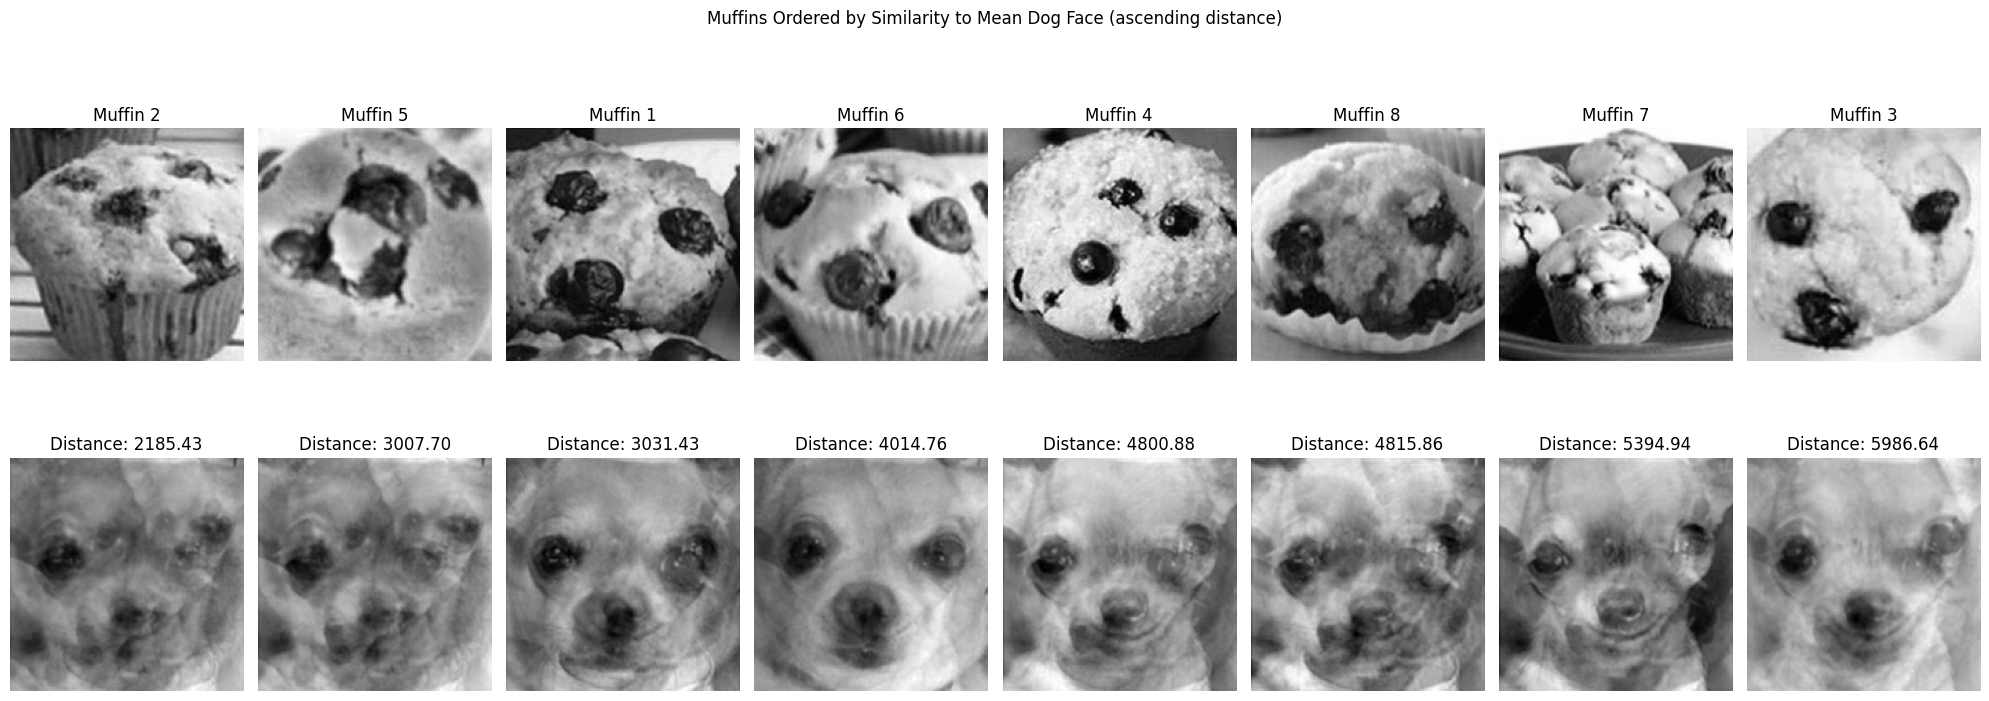

In [41]:
distances = []

for i, reconstructed_muffin in enumerate(reconstructed_muffins):

    flat_reconstructed = reconstructed_muffin.flatten()
    

    distance = np.linalg.norm(flat_reconstructed - mean_image)
    distances.append((i+1, distance))  
    


sorted_distances = sorted(distances, key=lambda x: x[1])



plt.figure(figsize=(20, 8))
plt.suptitle("Muffins Ordered by Similarity to Mean Dog Face (ascending distance)")


for i, (muffin_idx, _) in enumerate(sorted_distances):
    plt.subplot(2, 8, i+1)
    plt.imshow(muffin_images[muffin_idx-1], cmap='gray')
    plt.title(f"Muffin {muffin_idx}")
    plt.axis('off')


for i, (muffin_idx, dist) in enumerate(sorted_distances):
    plt.subplot(2, 8, i+9)
    plt.imshow(reconstructed_muffins[muffin_idx-1], cmap='gray')
    plt.title(f"Distance: {dist:.2f}")
    plt.axis('off')

plt.tight_layout()
plt.show()

##### Discussion of Results

The chihuaha detector in this implementation was interesting, because honestly I was not too sure of its results. It was extremely cool how it was able to "dog-ify" a muffin, which shows the power of the PCA method. 

However, just by inspection in this example, it does not seem to be so good at classification. The second most "dog-like" muffin in my human opinion is Muffin 3 (After muffin 4), which actually had the greatest Euclidian distance in this example. I think this is because while we're dealing with manipulating and judging pixel patterns with this method, we're not identifying any qualitative features or anything.

#### Question 3 : Classifiers


In [68]:
###Pokemon classifier


pokemon_classes = ['Pikachu', 'Squirtle', 'Bulbasaur', 'Charizard', 'Dragonite']

training_images = []
test_images = []

training_images_gray = []
test_images_gray = []

training_features = []
test_features = []
training_labels = []
test_labels = []


def load_pokemon_images(type, class_name):
    if type == 'train':
        n = 10
    else:
        n = 5

    for i in range(1, n+1):
        image_path = f"{path}/Q3/{class_name}/{type}/{type}_{i}.jpg"
        image = cv2.imread(image_path)
        
        if image is None:
            print(f"Warning: Image {image_path} not found.")
            continue  

        #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (128, 128))
        
        if type == 'train':
            training_images.append((image, class_name))
        else:
            test_images.append((image, class_name))

        gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        if type == 'train':
            training_images_gray.append((gray_image, class_name))
        else:
            test_images_gray.append((gray_image, class_name))

     
        hog_features = extract_hog_features(gray_image)
        color_hist_features = extract_color_histogram(image)

  
        final_feature_vector = np.concatenate([hog_features, color_hist_features])


        if type == 'train':
            training_features.append(final_feature_vector)
            training_labels.append(class_name)
        else:
            test_features.append(final_feature_vector)
            test_labels.append(class_name)

def extract_hog_features(gray_image):
  
    win_size = (128, 128)  
    block_size = (16, 16)
    block_stride = (8, 8)
    cell_size = (8, 8)
    nbins = 9

    hog_descriptor = cv2.HOGDescriptor(win_size, block_size, block_stride, cell_size, nbins)
    hog_features = hog_descriptor.compute(gray_image)

    # Apply L2 normalization manually because skimage was not running
    hog_features /= np.linalg.norm(hog_features, ord=2) if np.linalg.norm(hog_features, ord=2) > 0 else 1

    return hog_features.flatten()

def extract_color_histogram(image, bins=32):
    hist_r = cv2.calcHist([image], [0], None, [bins], [0, 256])
    hist_g = cv2.calcHist([image], [1], None, [bins], [0, 256])
    hist_b = cv2.calcHist([image], [2], None, [bins], [0, 256])

    hist_r /= hist_r.sum() if hist_r.sum() > 0 else 1
    hist_g /= hist_g.sum() if hist_g.sum() > 0 else 1
    hist_b /= hist_b.sum() if hist_b.sum() > 0 else 1


    color_hist_features = np.concatenate([hist_r, hist_g, hist_b]).flatten()
    return color_hist_features


for class_name in pokemon_classes:
    load_pokemon_images('train', class_name)
    load_pokemon_images('test', class_name)


X_train = np.array(training_features)
y_train = np.array(training_labels)

X_test = np.array(test_features)
y_test = np.array(test_labels)

print("Feature extraction complete!")
print(f"Training set: {X_train.shape}, Labels: {y_train.shape}")
print(f"Test set: {X_test.shape}, Labels: {y_test.shape}")



    


Feature extraction complete!
Training set: (50, 8196), Labels: (50,)
Test set: (25, 8196), Labels: (25,)


In [76]:
# Training 5 different SVM classifiers
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score


# 1. Linear SVM
linear_svm = SVC(kernel='linear', C=1.0)
linear_svm.fit(X_train, y_train)
linear_pred = linear_svm.predict(X_test)
linear_accuracy = accuracy_score(y_test, linear_pred)
print(f"Linear SVM (C=1.0) Accuracy: {linear_accuracy:.4f}")

# 2. RBF SVM
rbf_svm1 = SVC(kernel='rbf', C=1.0, gamma=0.001)
rbf_svm1.fit(X_train, y_train)
rbf1_pred = rbf_svm1.predict(X_test)
rbf1_accuracy = accuracy_score(y_test, rbf1_pred)
print(f"RBF SVM (γ=0.001) Accuracy: {rbf1_accuracy:.4f}")

# 3. RBF SVM 
rbf_svm2 = SVC(kernel='rbf', C=1.0, gamma= 10)
rbf_svm2.fit(X_train, y_train)
rbf2_pred = rbf_svm2.predict(X_test)
rbf2_accuracy = accuracy_score(y_test, rbf2_pred)
print(f"RBF SVM (γ=10) Accuracy: {rbf2_accuracy:.4f}")

# 4. Polynomial SVM
poly_svm1 = SVC(kernel='poly', C=2, degree=2)
poly_svm1.fit(X_train, y_train)
poly1_pred = poly_svm1.predict(X_test)
poly1_accuracy = accuracy_score(y_test, poly1_pred)
print(f"Polynomial SVM (degree=2) Accuracy: {poly1_accuracy:.4f}")

# 5. Polynomial SVM 
poly_svm2 = SVC(kernel='poly', C=1.0, degree=5)
poly_svm2.fit(X_train, y_train)
poly2_pred = poly_svm2.predict(X_test)
poly2_accuracy = accuracy_score(y_test, poly2_pred)
print(f"Polynomial SVM (degree=5) Accuracy: {poly2_accuracy:.4f}")

models = [
    {"name": "Linear SVM", "model": linear_svm, "accuracy": linear_accuracy, "predictions": linear_pred},
    {"name": "RBF SVM (γ=0.001)", "model": rbf_svm1, "accuracy": rbf1_accuracy, "predictions": rbf1_pred},
    {"name": "RBF SVM (γ=10)", "model": rbf_svm2, "accuracy": rbf2_accuracy, "predictions": rbf2_pred},
    {"name": "Polynomial SVM (degree=2)", "model": poly_svm1, "accuracy": poly1_accuracy, "predictions": poly1_pred},
    {"name": "Polynomial SVM (degree=5)", "model": poly_svm2, "accuracy": poly2_accuracy, "predictions": poly2_pred}
]


best_model = max(models, key=lambda x: x["accuracy"])
print(f"\nBest performing model: {best_model['name']} with accuracy {best_model['accuracy']:.4f}")

# Compare all models
print("\nModel Comparison:")
print("-" * 60)
print(f"{'Model':<25} | {'Accuracy':<10}")
print("-" * 60)
for model in models:
    print(f"{model['name']:<25} | {model['accuracy']:.4f}")
print("-" * 60)

Linear SVM (C=1.0) Accuracy: 0.6400
RBF SVM (γ=0.001) Accuracy: 0.4800
RBF SVM (γ=10) Accuracy: 0.5600
Polynomial SVM (degree=2) Accuracy: 0.7600
Polynomial SVM (degree=5) Accuracy: 0.6800

Best performing model: Polynomial SVM (degree=2) with accuracy 0.7600

Model Comparison:
------------------------------------------------------------
Model                     | Accuracy  
------------------------------------------------------------
Linear SVM                | 0.6400
RBF SVM (γ=0.001)         | 0.4800
RBF SVM (γ=10)            | 0.5600
Polynomial SVM (degree=2) | 0.7600
Polynomial SVM (degree=5) | 0.6800
------------------------------------------------------------


Type of first test label: <class 'numpy.str_'>
First few test labels: ['Pikachu' 'Pikachu' 'Pikachu' 'Pikachu' 'Pikachu']
Pokemon classes: ['Pikachu', 'Squirtle', 'Bulbasaur', 'Charizard', 'Dragonite']


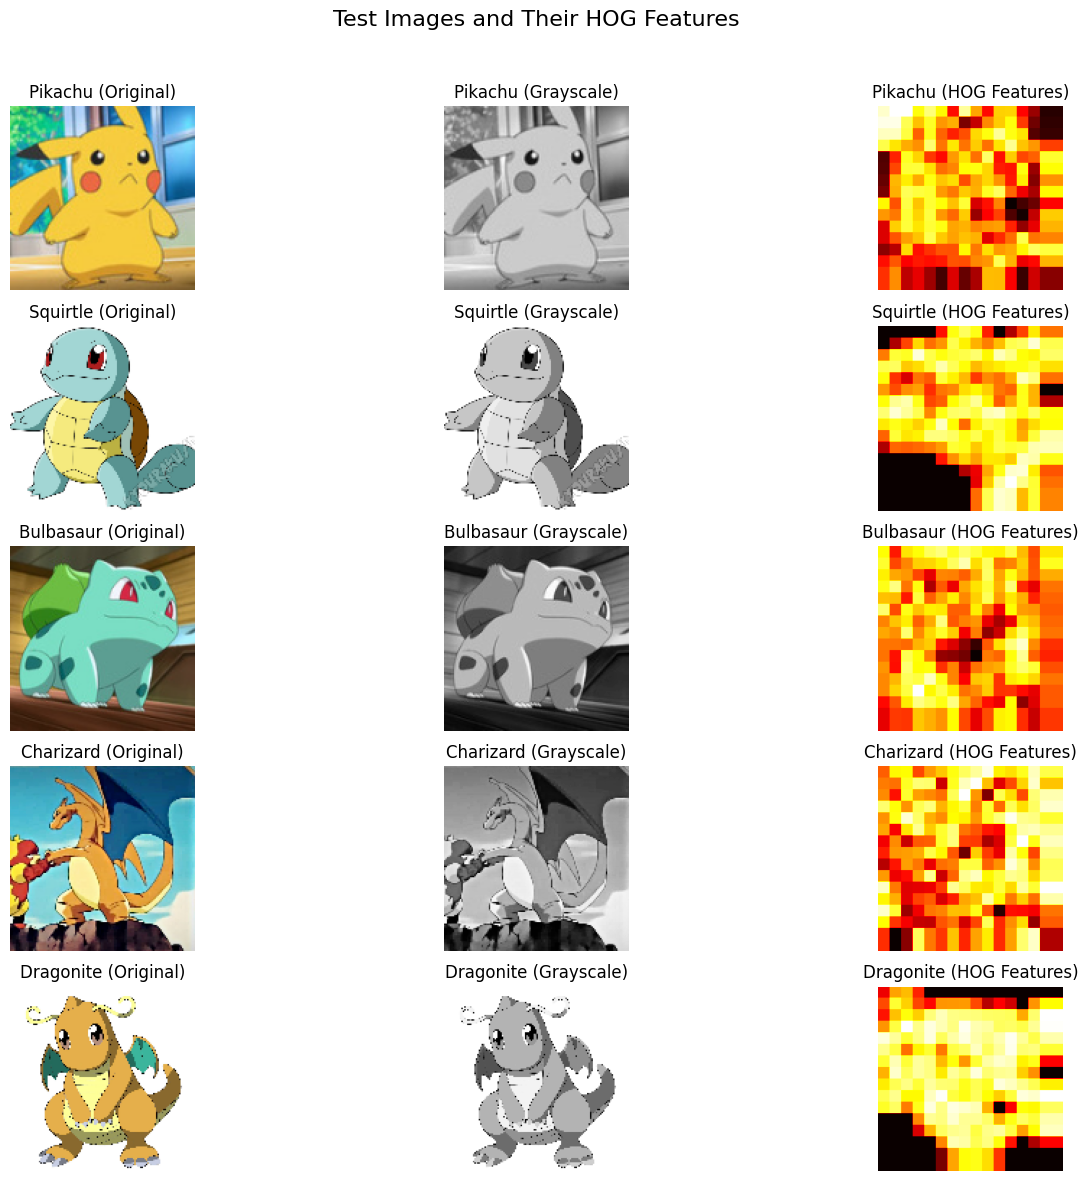

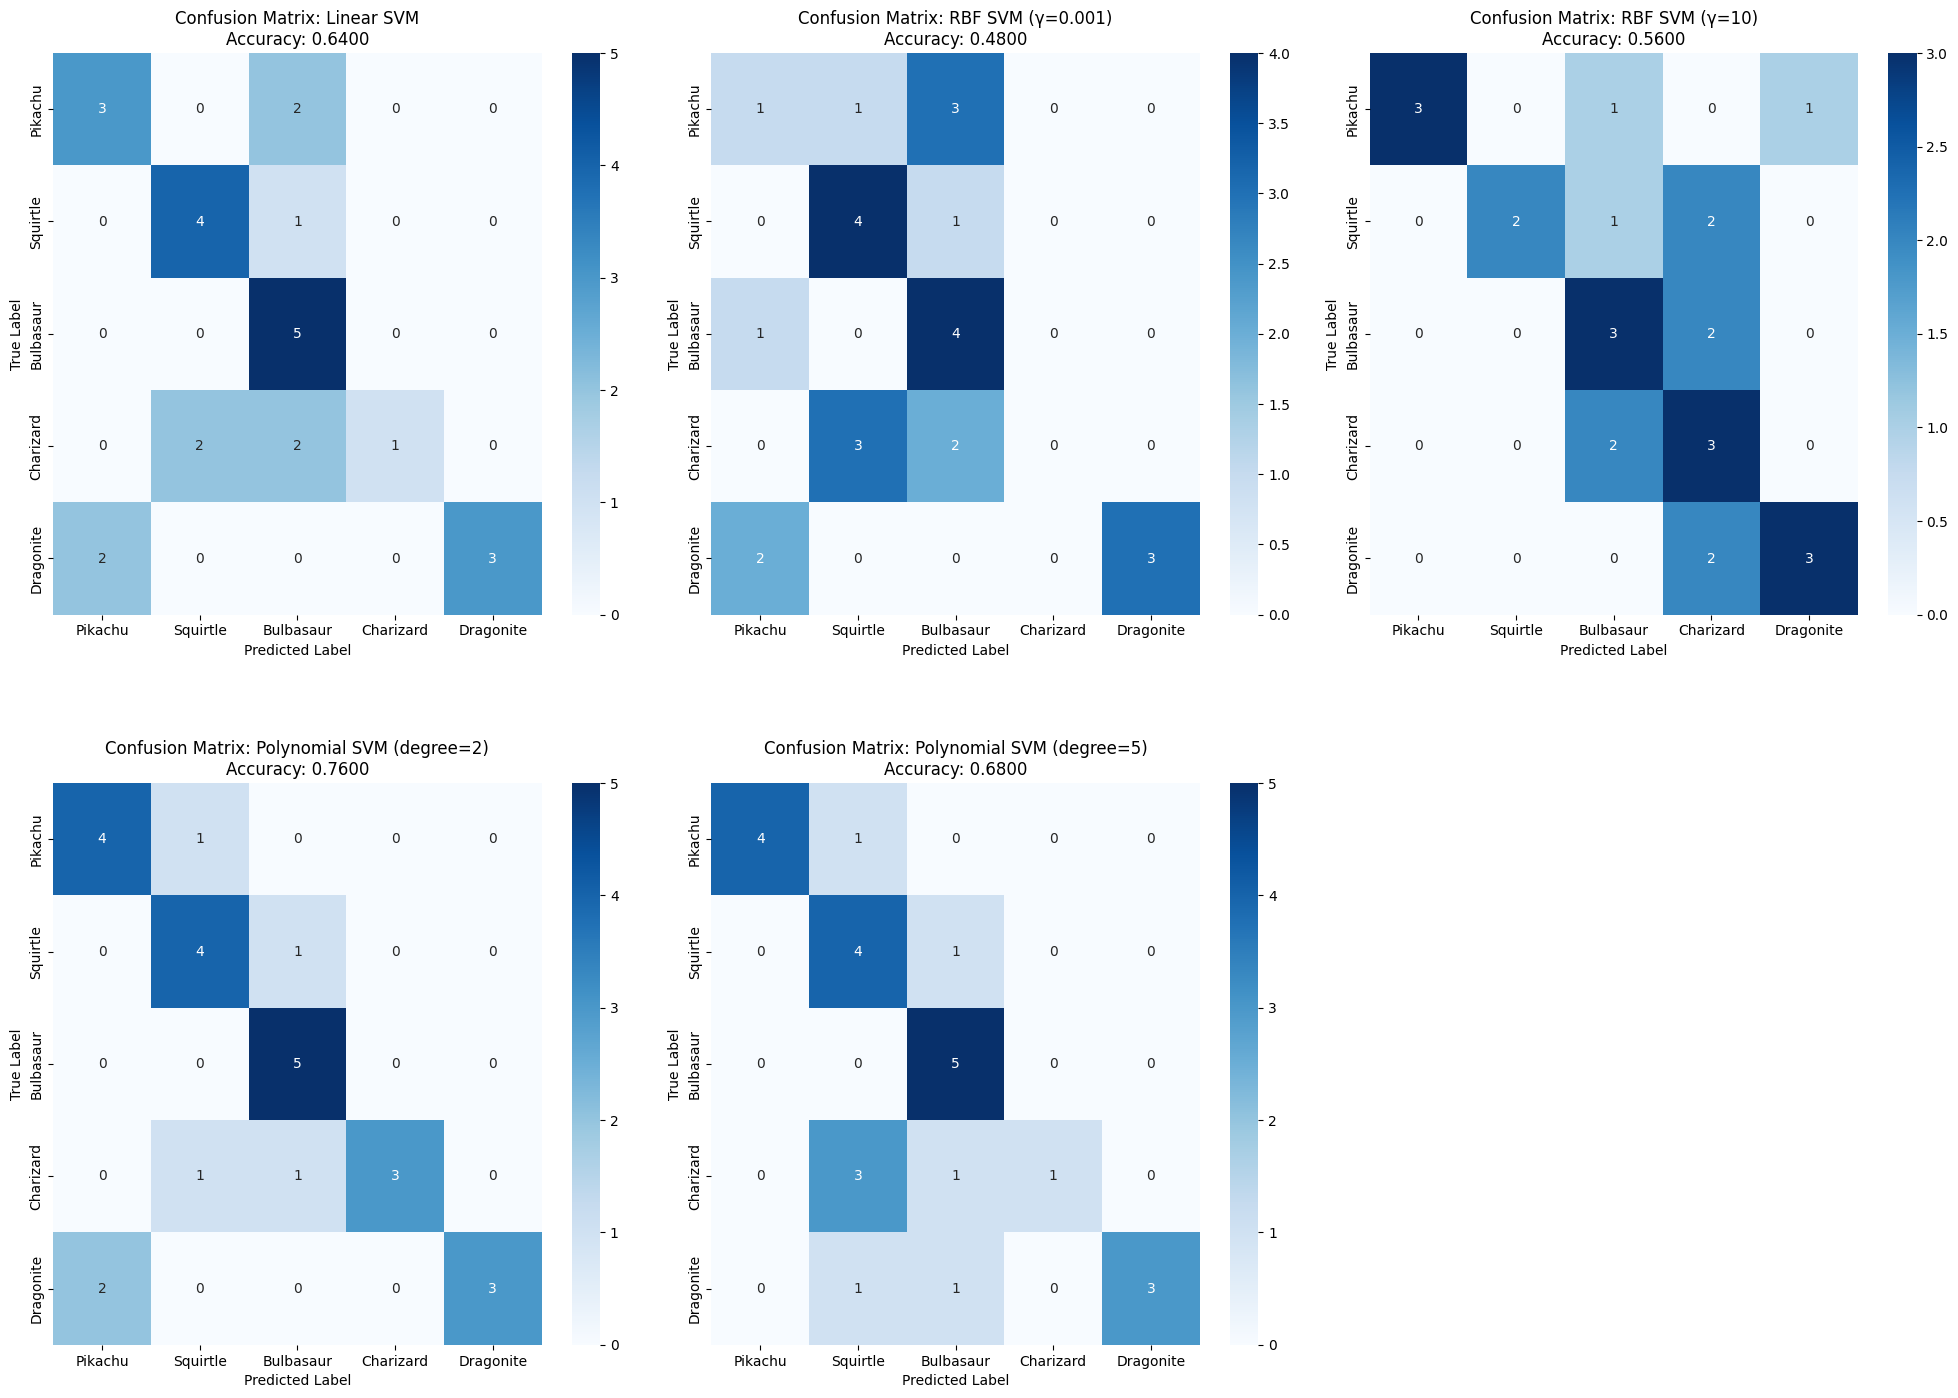

In [77]:

import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

def visualize_hog(img):
  
    

    win_size = (128, 128)
    block_size = (16, 16)
    block_stride = (8, 8)
    cell_size = (8, 8)
    nbins = 9
    
    hog_descriptor = cv2.HOGDescriptor(win_size, block_size, block_stride, cell_size, nbins)
    hog_features = hog_descriptor.compute(gray_img)

    hog_features /= np.linalg.norm(hog_features, ord=2) if np.linalg.norm(hog_features, ord=2) > 0 else 1
    
  
    num_blocks_x = (win_size[0] - block_size[0]) // block_stride[0] + 1
    num_blocks_y = (win_size[1] - block_size[1]) // block_stride[1] + 1
    hog_image = np.zeros((win_size[0], win_size[1]))
    
    for y in range(num_blocks_y):
        for x in range(num_blocks_x):
            block_start = (y * num_blocks_x + x) * nbins * 4  # 4 cells per block
            block_strength = np.sum(hog_features[block_start:block_start + nbins * 4])
            y_pos = y * block_stride[0]
            x_pos = x * block_stride[0]
            hog_image[y_pos:y_pos + block_size[0], x_pos:x_pos + block_size[1]] = block_strength
    
   
    hog_image = (hog_image - hog_image.min()) / (hog_image.max() - hog_image.min() + 1e-10)
    
    return hog_image


test_images_for_vis = []
test_images_dict = {}


print(f"Type of first test label: {type(y_test[0])}")
print(f"First few test labels: {y_test[:5]}")
print(f"Pokemon classes: {pokemon_classes}")


for i, label in enumerate(y_test):

    if isinstance(label, str):
        pokemon_name = label
    else:
        
        try:
            pokemon_name = pokemon_classes[label]
        except IndexError:
            print(f"Warning: Label {label} is out of range for pokemon_classes list")
            continue
    
    if pokemon_name not in test_images_dict:
        test_images_dict[pokemon_name] = [test_images[i]]
    else:
        test_images_dict[pokemon_name].append(test_images[i])


plt.figure(figsize=(15, 12))
plt.suptitle("Test Images and Their HOG Features", fontsize=16)


for i, class_name in enumerate(pokemon_classes):
    if i >= 5:  
        break
        
    if class_name in test_images_dict and len(test_images_dict[class_name]) > 0:

        test_img, _ = test_images_dict[class_name][0]  
        

        
      
        plt.subplot(5, 3, i*3 + 1)
        plt.imshow(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB))
        plt.title(f"{class_name} (Original)")
        plt.axis('off')

        plt.subplot(5, 3, i*3 + 2)
        gray_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY)
        plt.imshow(gray_img, cmap='gray')
        plt.title(f"{class_name} (Grayscale)")
        plt.axis('off')
        
    
        plt.subplot(5, 3, i*3 + 3)
        hog_img = visualize_hog(test_img)
        plt.imshow(hog_img, cmap='hot')
        plt.title(f"{class_name} (HOG Features)")
        plt.axis('off')


plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()


plt.figure(figsize=(20, 15))

for i, model_info in enumerate(models):
    if i >= 5:  # We only have 5 models
        break
        
    plt.subplot(2, 3, i+1)
    
  
    try:
        cm = confusion_matrix(y_test, model_info["predictions"])
        
    
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=pokemon_classes,
                   yticklabels=pokemon_classes)
        
        plt.title(f"Confusion Matrix: {model_info['name']}\nAccuracy: {model_info['accuracy']:.4f}")
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
    except Exception as e:
        print(f"Error creating confusion matrix for {model_info['name']}: {e}")
        continue

plt.tight_layout()
plt.subplots_adjust(top=0.9, hspace=0.3)
plt.show()



#### Discussion

In my case, a 2 degree polynomial SVM performed best with an accuracy of 72%. I played with it a bit and found that slightly more regularization with C = 2.0 which bumped it up to 76%. 

The choice of kernel made a significant difference. The best performing RBF was still 20% less accurate than the best polynomial kernel. I found this a bit odd actually because I expected the RBF to perform better. At first glance, there does not seem to be anything quadratic about this data, and I expected the RBF to capture the non-linear parts better. 

I think the challenges can be seen when looking at the hog features heatmap. Something like the pikachu is basically a blob, where the charizard has wings and a long neck and more intricate features. I think this comes across in the hog representation. Perhaps a better resolution hog could solve this though it would be more computationally expensive.

I expected Bulbasaur and Squirtle to get misclassified a lot more, and they were misclassified, but interestingly just once every time. I was pleasantly suprised. Bulbasaur in general was predicted a few times where the reality was something else. It may just be the fact that it has quite a generic shape. 
